In [2]:
import os
import pandas as pd
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import timm

from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, r2_score

In [16]:
# === CONFIG ===
CSV_PATH = "/jupyterlab/VisionInspect/data/part_labels.csv"
DATA_ROOT = "/VisionInspect/data"
MODEL_SAVE_PATH = "/VisionInspect/models/convnext_large.pth"
NUM_CLASSES = 6
BATCH_SIZE = 64
NUM_EPOCHS = 3
IMAGE_SIZE = 512
USE_MIXED_PRECISION = True
VALID_SPLIT = 0.2
#DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE = torch.device("cuda")
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [17]:
# === DATASET ===
class PartDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[idx, 0])
        label = self.annotations.iloc[idx, 1]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, PartDataset.class_to_idx[label]

    @staticmethod
    def prepare_class_index_map(class_names):
        PartDataset.class_to_idx = {cls: idx for idx, cls in enumerate(class_names)}
        PartDataset.idx_to_class = {idx: cls for cls, idx in PartDataset.class_to_idx.items()}

In [18]:
# === TRANSFORMS WITH AUGMENTATION ===
transform_train = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

transform_val = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [29]:
# === LOAD DATA ===
class_names = ['bolt', 'gear', 'nut', 'washer', 'bearing', 'connector']
PartDataset.prepare_class_index_map(class_names)
full_dataset = PartDataset(CSV_PATH, DATA_ROOT, transform=transform_train)

val_size = int(len(full_dataset) * VALID_SPLIT)
train_size = len(full_dataset) - val_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
val_dataset.dataset.transform = transform_val

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [20]:
# === MODEL ===
torch.cuda.empty_cache()
model = timm.create_model('convnext_large', pretrained=True, num_classes=NUM_CLASSES, drop_rate=0.3)
model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scaler = torch.amp.GradScaler(device = 'cuda', enabled=USE_MIXED_PRECISION)

In [21]:
# === TRAIN LOOP WITH VALIDATION ===
for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{NUM_EPOCHS}]")

    for images, labels in loop:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()

        with torch.cuda.amp.autocast(enabled=USE_MIXED_PRECISION):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        loop.set_postfix(loss=loss.item(), acc=100.0 * correct / total)

    print(f"✅ Epoch {epoch+1} Training Accuracy: {100.0 * correct / total:.2f}%")

/w0/tmp/slurm_kt226005.56165959/ipykernel_805/1929699746.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_MIXED_PRECISION):
Epoch [1/3]: 100%|██████████| 43/43 [00:29<00:00,  1.44it/s, acc=86.4, loss=0.000503]


✅ Epoch 1 Training Accuracy: 86.36%


Epoch [2/3]: 100%|██████████| 43/43 [00:25<00:00,  1.67it/s, acc=100, loss=0.000195]


✅ Epoch 2 Training Accuracy: 100.00%


Epoch [3/3]: 100%|██████████| 43/43 [00:25<00:00,  1.70it/s, acc=100, loss=0.000153]

✅ Epoch 3 Training Accuracy: 100.00%


In [22]:
    # === VALIDATION ===
    model.eval()
    val_preds = []
    val_labels = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            with torch.cuda.amp.autocast(enabled=USE_MIXED_PRECISION):
                outputs = model(images)
            preds = outputs.argmax(dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    precision = precision_score(val_labels, val_preds, average='weighted', zero_division=0)
    recall = recall_score(val_labels, val_preds, average='weighted', zero_division=0)
    f1 = f1_score(val_labels, val_preds, average='weighted', zero_division=0)
    r2 = r2_score(val_labels, val_preds) if len(set(val_labels)) > 1 else 0.0

    print(f"Validation Precision: {precision:.4f}")
    print(f"Validation Recall:    {recall:.4f}")
    print(f"Validation F1 Score:  {f1:.4f}")
    print(f"Validation R2 Score:  {r2:.4f}")
    print("Classification Report:")
    print(classification_report(val_labels, val_preds, target_names=class_names))

/w0/tmp/slurm_kt226005.56165959/ipykernel_805/1322488971.py:8: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_MIXED_PRECISION):


🔍 Validation Precision: 1.0000
🔍 Validation Recall:    1.0000
🔍 Validation F1 Score:  1.0000
🔍 Validation R2 Score:  1.0000
📊 Classification Report:
              precision    recall  f1-score   support

        bolt       1.00      1.00      1.00       110
        gear       1.00      1.00      1.00       120
         nut       1.00      1.00      1.00       124
      washer       1.00      1.00      1.00        83
     bearing       1.00      1.00      1.00       128
   connector       1.00      1.00      1.00       115

    accuracy                           1.00       680
   macro avg       1.00      1.00      1.00       680
weighted avg       1.00      1.00      1.00       680



In [ ]:
# === SAVE MODEL ===
os.makedirs(os.path.dirname(MODEL_SAVE_PATH), exist_ok=True)
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print("Model saved to {}".format(MODEL_SAVE_PATH))

In [31]:
#Sanity - Overlap Check
import pandas as pd
#from train_classifier import PartDataset  # Assuming same file or shared environment

# Load CSV again
df = pd.read_csv(CSV_PATH)
PartDataset.prepare_class_index_map(['bolt', 'gear', 'nut', 'washer', 'bearing', 'connector'])

# Recreate full dataset with index mapping
full_dataset = PartDataset(CSV_PATH, "data")
val_size = int(len(full_dataset) * 0.2)
train_size = len(full_dataset) - val_size

from torch.utils.data import random_split
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Extract paths from indices (match CSV paths)
train_paths = set(df.iloc[train_dataset.indices]['filepath'].values)
val_paths = set(df.iloc[val_dataset.indices]['filepath'].values)

# Check overlap
overlapping_paths = train_paths.intersection(val_paths)
print(f"Number of overlapping file paths in train and validation sets: {len(overlapping_paths)}")
if overlapping_paths:
    print("Overlap detected! Examples:")
    for i, path in enumerate(list(overlapping_paths)[:10]):
        print(f" - {path}")
else:
    print("No overlap. Train/Validation split is clean.")


🔍 Number of overlapping file paths in train and validation sets: 0
✅ No overlap. Train/Validation split is clean.


/w0/tmp/slurm_kt226005.56165959/ipykernel_805/2202229213.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/rwthfs/rz/cluster/home/kt2260

🔄 Domain Shift Accuracy: 99.50%
🔮 Avg Prediction Confidence: 0.9704


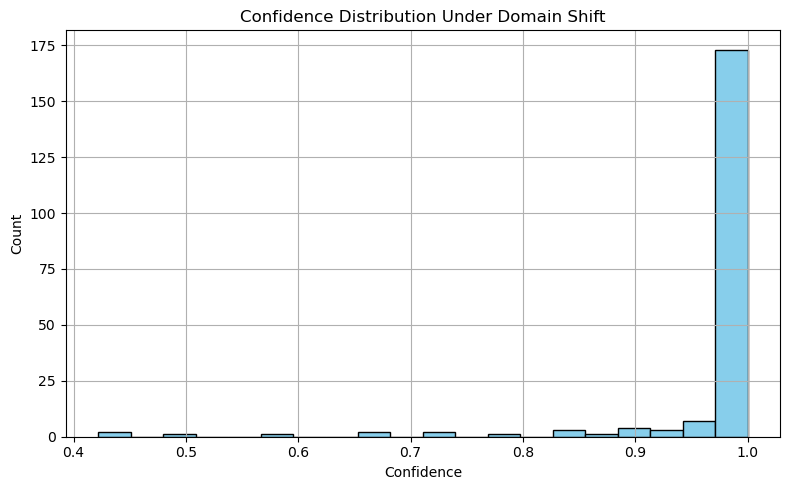

In [36]:
#Domain Shift Model Performance Check
import pandas as pd
from PIL import Image, ImageEnhance, ImageFilter
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

# === LOAD MODEL ===
model = timm.create_model('convnext_large', pretrained=False, num_classes=NUM_CLASSES)
model.load_state_dict(torch.load("/VisionInspect/models/convnext_large.pth", map_location=DEVICE))
model.eval().to(DEVICE)

# === CLASS INDEX ===
class_names = ['bolt', 'gear', 'nut', 'washer', 'bearing', 'connector']
class_to_idx = {cls: idx for idx, cls in enumerate(class_names)}
idx_to_class = {v: k for k, v in class_to_idx.items()}

# === DOMAIN SHIFT TRANSFORMS ===
# Simulate low-light, blur, and pose (rotation)
def domain_shift(img: Image.Image) -> Image.Image:
    img = img.convert("RGB")
    img = ImageEnhance.Brightness(img).enhance(0.5)  # simulate low light
    img = img.rotate(20)  # slight rotational change
    img = img.filter(ImageFilter.GaussianBlur(radius=1.5))  # blur
    return img

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# === EVALUATE ON SHIFTED IMAGES ===
df = pd.read_csv(CSV_PATH)
correct = 0
total = 0
confidences = []
predictions = []
truths = []

sample_paths = df.sample(200, random_state=42).reset_index(drop=True)  # Test on subset

for _, row in tqdm(sample_paths.iterrows(), total=len(sample_paths)):
    path = os.path.join(DATA_ROOT, row['filepath'])
    label = class_to_idx[row['label']]
    
    try:
        img = Image.open(path)
        shifted_img = domain_shift(img)
        input_tensor = transform(shifted_img).unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            output = model(input_tensor)
            pred = output.argmax(dim=1).item()
            conf = torch.softmax(output, dim=1)[0, pred].item()

        correct += (pred == label)
        confidences.append(conf)
        predictions.append(pred)
        truths.append(label)
        total += 1
    except:
        continue

accuracy = correct / total
avg_conf = np.mean(confidences)

print(f"Domain Shift Accuracy: {accuracy*100:.2f}%")
print(f"🔮 Avg Prediction Confidence: {avg_conf:.4f}")

# === PLOT CONFIDENCE HISTOGRAM ===
plt.figure(figsize=(8, 5))
plt.hist(confidences, bins=20, color='skyblue', edgecolor='black')
plt.title("Confidence Distribution Under Domain Shift")
plt.xlabel("Confidence")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()
